## YOLOv3

In [ ]:

# 0) 환경
import os, json, math, random, shutil, zipfile, gc
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps, ImageEnhance, ImageDraw, ImageFont
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_SIZE = 416
SCALES = [13,26,52]
STRIDES = [32,16,8]
ANCHORS = [(10,13),(16,30),(33,23),(30,61),(62,45),(59,119),(116,90),(156,198),(373,326)]
ANCHORS_SCALED = {52:ANCHORS[0:3], 26:ANCHORS[3:6], 13:ANCHORS[6:9]}

print('DEVICE =', DEVICE)


DEVICE = cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# 1) drawings.zip unzip + 경로 복구
zip_candidates = [Path("/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/drawings.zip")]
zip_path = None
for c in zip_candidates:
    if c.exists():
        zip_path = c; break
assert zip_path is not None, "drawings.zip을 같은 경로에 업로드하세요."

root = Path("./data_drawings_v3_fixed")
if root.exists(): shutil.rmtree(root)
root.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root)

# 원천/라벨 폴더 유추
src_dir = None; lbl_dir = None
for p in root.rglob("*"):
    if p.is_dir() and "원천" in p.name:
        src_dir = p
    if p.is_dir() and "라벨" in p.name:
        lbl_dir = p
if lbl_dir is None:
    # json이 있는 곳을 라벨로
    cand = list(root.rglob("*.json"))
    assert cand, "라벨 JSON을 찾을 수 없습니다."
    lbl_dir = cand[0].parent
if src_dir is None:
    # 이미지 폴더 최상위 추정
    imgs = list(root.rglob("*.jpg")) + list(root.rglob("*.png"))
    assert imgs, "이미지 파일을 찾을 수 없습니다."
    src_dir = imgs[0].parents[2] if len(imgs[0].parents)>=2 else root

print("src_dir:", src_dir)
print("lbl_dir:", lbl_dir)

def letterbox(im, new_size=INPUT_SIZE, color=(114,114,114)):
    w,h = im.size
    s = min(new_size/w, new_size/h)
    nw, nh = int(w*s), int(h*s)
    im_r = im.resize((nw,nh), Image.BILINEAR)
    canvas = Image.new('RGB', (new_size,new_size), color)
    pad_x = (new_size-nw)//2; pad_y=(new_size-nh)//2
    canvas.paste(im_r, (pad_x,pad_y))
    return canvas, s, pad_x, pad_y


src_dir: data_drawings_v3_fixed/Sample/01.원천데이터
lbl_dir: data_drawings_v3_fixed/Sample/02.라벨링데이터


In [ ]:

# 2) JSON 파싱 (경로 복구 강력)
def resolve_img_path(rel_or_name: str):
    p = (lbl_dir / rel_or_name).resolve()
    if p.exists():
        return p
    # 이름으로 전체 검색
    name = Path(rel_or_name).name
    for ext in ["*.jpg","*.jpeg","*.png","*.bmp"]:
        hits = list(root.rglob(ext))
        hits = [h for h in hits if h.name == name]
        if hits:
            return hits[0]
    # 마지막 시도: 동일 stem
    stem = Path(rel_or_name).stem
    hits = [h for h in root.rglob("*.*") if h.stem == stem and h.suffix.lower() in [".jpg",".jpeg",".png",".bmp"]]
    if hits:
        return hits[0]
    return None

def parse_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    meta = d.get("meta", {})
    anns = d.get("annotations", {})
    bboxes = anns.get("bbox", [])
    img_rel = meta.get("img_path") or meta.get("image_path") or meta.get("file_path")
    img_path = resolve_img_path(img_rel if img_rel else Path(json_path).with_suffix(".jpg").name)
    return {"img_path": img_path, "bboxes": bboxes}

json_list = sorted(lbl_dir.rglob("*.json"))
items = []
from collections import Counter
label_counter = Counter()

for jp in json_list:
    info = parse_json(jp)
    if info["img_path"] is None or not Path(info["img_path"]).exists():
        continue
    # 표준화: bbox dict: x,y,w,h,label
    fixed = []
    for bb in info["bboxes"]:
        x = float(bb.get("x", bb.get("left", 0)))
        y = float(bb.get("y", bb.get("top", 0)))
        w = float(bb.get("w", bb.get("width", 0)))
        h = float(bb.get("h", bb.get("height", 0)))
        lab = bb.get("label", "unknown")
        if w>0 and h>0:
            fixed.append({"x":x,"y":y,"w":w,"h":h,"label":lab})
            label_counter[lab]+=1
    if fixed:
        items.append({"img_path": info["img_path"], "bboxes": fixed})

assert items, "유효 라벨이 없습니다."
classes = sorted(label_counter.keys())
cls2idx = {c:i for i,c in enumerate(classes)}
idx2cls = {i:c for c,i in cls2idx.items()}
num_classes = len(classes)
print("items:", len(items), "classes:", num_classes)
print("top labels:", label_counter.most_common(10))


items: 560 classes: 47
top labels: [('꽃', 637), ('눈', 560), ('팔', 560), ('발', 560), ('운동화', 560), ('다리', 559), ('귀', 557), ('손', 557), ('잔디', 525), ('주머니', 517)]


In [ ]:

# 3) Dataset
def build_targets_yolov3(bboxes, num_classes):
    targets = {}
    for S,stride in zip(SCALES, STRIDES):
        A=3
        T = np.zeros((S,S,A,5+num_classes), np.float32)
        targets[S]=T
    for bb in bboxes:
        x,y,w,h,lab = bb["x"],bb["y"],bb["w"],bb["h"],bb["label"]
        cx,cy = x+w/2, y+h/2
        best_S,best_a,best_iou=None,None,-1.0
        for S,stride in zip(SCALES,STRIDES):
            anchors = np.array(ANCHORS_SCALED[S], np.float32)
            inter = np.minimum(w,anchors[:,0])*np.minimum(h,anchors[:,1])
            union = (w*h)+(anchors[:,0]*anchors[:,1])-inter+1e-9
            ious = inter/union
            a = int(np.argmax(ious))
            if ious[a]>best_iou:
                best_iou=float(ious[a]); best_S=S; best_a=a
        S=best_S; stride=INPUT_SIZE//S
        gx,gy=int(cx//stride), int(cy//stride)
        if not (0<=gx<S and 0<=gy<S): continue
        tx=(cx/stride)-gx; ty=(cy/stride)-gy
        aw,ah=ANCHORS_SCALED[S][best_a]
        tw=math.log(max(w,1e-6)/aw); th=math.log(max(h,1e-6)/ah)
        T=targets[S]
        T[gy,gx,best_a,0]=tx; T[gy,gx,best_a,1]=ty
        T[gy,gx,best_a,2]=tw; T[gy,gx,best_a,3]=th
        T[gy,gx,best_a,4]=1.0
        cid=cls2idx.get(lab,-1)
        if cid>=0: T[gy,gx,best_a,5+cid]=1.0
    return targets

def letterbox(im, new_size=INPUT_SIZE, color=(114,114,114)):
    w,h=im.size
    s=min(new_size/w,new_size/h); nw,nh=int(w*s),int(h*s)
    im_r=im.resize((nw,nh), Image.BILINEAR)
    canvas=Image.new('RGB',(new_size,new_size),color); px=(new_size-nw)//2; py=(new_size-nh)//2
    canvas.paste(im_r,(px,py))
    return canvas,s,px,py

class DS(torch.utils.data.Dataset):
    def __init__(self, items, augment=True):
        self.items=items; self.augment=augment
    def __len__(self): return len(self.items)
    def __getitem__(self,idx):
        it=self.items[idx]
        im=Image.open(it["img_path"]).convert("RGB")
        im_lb, s, px, py = letterbox(im, INPUT_SIZE)
        # 416 픽셀 좌표로 보정
        fixed=[]
        for bb in it["bboxes"]:
            x=bb["x"]*s+px; y=bb["y"]*s+py; w=bb["w"]*s; h=bb["h"]*s
            fixed.append({"x":x,"y":y,"w":w,"h":h,"label":bb["label"]})
        T = build_targets_yolov3(fixed, num_classes)
        arr = np.asarray(im_lb, np.float32)/255.0
        arr = np.transpose(arr,(2,0,1))
        img = torch.from_numpy(arr)
        targets = {S: torch.from_numpy(T[S]) for S in SCALES}
        return img, targets

# split
random.seed(0)
perm=list(range(len(items))); random.shuffle(perm)
cut=int(len(perm)*0.9)
train_items=[items[i] for i in perm[:cut]]
val_items=[items[i] for i in perm[cut:]]
train_loader=DataLoader(DS(train_items), batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader=DataLoader(DS(val_items, augment=False), batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
print("train/val:", len(train_items), len(val_items))


train/val: 504 56


In [ ]:

# 4) 모델
def conv_bn_act(c_in, c_out, k=3, s=1, p=None):
    if p is None: p=(k-1)//2
    return nn.Sequential(
        nn.Conv2d(c_in,c_out,k,s,p,bias=False),
        nn.BatchNorm2d(c_out),
        nn.LeakyReLU(0.1, inplace=True),
    )

class ResBlk(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.c1=conv_bn_act(c,c//2,1,1,0)
        self.c2=conv_bn_act(c//2,c,3,1,1)
    def forward(self,x):
        return x + self.c2(self.c1(x))

class Darknet53(nn.Module):
    def __init__(self):
        super().__init__()
        self.s=conv_bn_act(3,32,3,1)
        self.d1=nn.Sequential(conv_bn_act(32,64,3,2), ResBlk(64))
        self.d2=nn.Sequential(conv_bn_act(64,128,3,2), *[ResBlk(128) for _ in range(2)])
        self.d3=nn.Sequential(conv_bn_act(128,256,3,2), *[ResBlk(256) for _ in range(8)])
        self.d4=nn.Sequential(conv_bn_act(256,512,3,2), *[ResBlk(512) for _ in range(8)])
        self.d5=nn.Sequential(conv_bn_act(512,1024,3,2), *[ResBlk(1024) for _ in range(4)])
    def forward(self,x):
        x=self.s(x); x=self.d1(x); x=self.d2(x)
        x52=self.d3(x); x26=self.d4(x52); x13=self.d5(x26)
        return x13,x26,x52

def yolo_head(c_in, c_out):
    seq = nn.Sequential(
        conv_bn_act(c_in,512,1,1,0),
        conv_bn_act(512,1024,3,1,1),
        conv_bn_act(1024,512,1,1,0),
        conv_bn_act(512,1024,3,1,1),
        conv_bn_act(1024,512,1,1,0),
    )
    pred = nn.Conv2d(512, c_out, 1,1,0)
    return seq, pred

class YOLOv3(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C=C
        self.back=Darknet53()
        # heads
        self.h13,self.p13=yolo_head(1024, 3*(5+C))
        self.red26=conv_bn_act(512,256,1,1,0)   # ← head13 출력(512ch)을 256으로 축소
        self.h26,self.p26=yolo_head(512+256, 3*(5+C))
        self.red52=conv_bn_act(512,128,1,1,0)   # ← head26 출력(512ch)을 128로 축소
        self.h52,self.p52=yolo_head(256+128, 3*(5+C))
        self.up=nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self,x):
        # 백본
        x13,x26,x52=self.back(x)   # x13: (N,1024,13,13), x26: (N,512,26,26), x52: (N,256,52,52)

        # 13x13 헤드
        h13=self.h13(x13)          # (N,512,13,13)
        p13=self.p13(h13)          # (N,3*(5+C),13,13)

        # 26x26 헤드: (h13 → 256 → 업샘플 26) ⊕ x26
        route26 = self.red26(h13)  # (N,256,13,13)
        u26 = self.up(route26)     # (N,256,26,26)
        h26 = torch.cat([u26, x26], dim=1)   # (N,256+512,26,26)
        h26 = self.h26(h26)        # (N,512,26,26)
        p26 = self.p26(h26)        # (N,3*(5+C),26,26)

        # 52x52 헤드: (h26 → 128 → 업샘플 52) ⊕ x52
        route52 = self.red52(h26)  # (N,128,26,26)
        u52 = self.up(route52)     # (N,128,52,52)
        h52 = torch.cat([u52, x52], dim=1)   # (N,128+256,52,52)
        h52 = self.h52(h52)        # (N,256,52,52)
        p52 = self.p52(h52)        # (N,3*(5+C),52,52)

        # reshape: (N,3,S,S,5+C)
        def reshape(p,S):
            N=p.shape[0]; A=3; C=5+self.C
            return p.view(N,A,C,S,S).permute(0,1,3,4,2).contiguous()

        return {13:reshape(p13,13), 26:reshape(p26,26), 52:reshape(p52,52)}

model = YOLOv3(len(classes)).to(DEVICE)
print("params(M):", sum(p.numel() for p in model.parameters())/1e6)


params(M): 73.615284


In [ ]:

# 5) 손실
class LossV3(nn.Module):
    def __init__(self, C, lambda_noobj=1.0):
        super().__init__(); self.C=C; self.lambda_noobj=lambda_noobj
    def forward(self, preds, tgts):
        tot=0.0; comp={"coord":0.0,"obj":0.0,"noobj":0.0,"cls":0.0}
        for S in [13,26,52]:
            p = preds[S]                 # (N,3,S,S,5+C)
            t = tgts[S].permute(0,3,1,2,4).to(p.device)  # (N,3,S,S,5+C)
            obj = t[...,4]==1.0
            no  = t[...,4]==0.0
            if obj.any():
                lxy = F.mse_loss(torch.sigmoid(p[...,0][obj]), t[...,0][obj], reduction='sum') + \
                      F.mse_loss(torch.sigmoid(p[...,1][obj]), t[...,1][obj], reduction='sum')
                lwh = F.mse_loss(p[...,2][obj], t[...,2][obj], reduction='sum') + \
                      F.mse_loss(p[...,3][obj], t[...,3][obj], reduction='sum')
                lobj= F.binary_cross_entropy_with_logits(p[...,4][obj], torch.ones_like(p[...,4][obj]), reduction='sum')
                lcls= F.binary_cross_entropy_with_logits(p[...,5:][obj], t[...,5:][obj], reduction='sum')
            else:
                lxy=lwh=lobj=lcls=torch.tensor(0.0, device=p.device)
            lno = F.binary_cross_entropy_with_logits(p[...,4][no], torch.zeros_like(p[...,4][no]), reduction='sum') if no.any() else torch.tensor(0.0, device=p.device)
            loss = lxy + lwh + lobj + self.lambda_noobj*lno + lcls
            tot = tot + loss
            comp["coord"]+=float((lxy+lwh).item()); comp["obj"]+=float(lobj.item()); comp["noobj"]+=float(lno.item()); comp["cls"]+=float(lcls.item())
        return tot/preds[13].shape[0], comp

criterion = LossV3(len(classes)).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)


In [ ]:

# 6) 퀵 학습 루프(원하면 EPOCHS ↑)
from tqdm import tqdm
def train_ep():
    model.train(); total=0.0
    for x,t in tqdm(train_loader, desc="train"):
        x=x.to(DEVICE).float()
        tt={S:t[S].to(DEVICE).float() for S in SCALES}
        p=model(x)
        loss,comp=criterion(p,tt)
        opt.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(),5.0); opt.step()
        total += loss.item()
    return total/len(train_loader)
@torch.no_grad()
def val_ep():
    model.eval(); total=0.0
    for x,t in val_loader:
        x=x.to(DEVICE).float(); tt={S:t[S].to(DEVICE).float() for S in SCALES}
        p=model(x); loss,_=criterion(p,tt); total+=loss.item()
    return total/len(val_loader)

EPOCHS=50  # 데모. 실제로는 20~100
for ep in range(1,EPOCHS+1):
    tl=train_ep(); vl=val_ep()
    print(f"[{ep:02d}] train={tl:.3f} val={vl:.3f}")


train: 100%|██████████| 63/63 [00:44<00:00,  1.42it/s]


[01] train=185.231 val=237.008


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[02] train=161.093 val=303.833


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[03] train=146.298 val=271.223


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[04] train=131.704 val=322.711


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[05] train=122.695 val=290.143


train: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


[06] train=117.205 val=238.105


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[07] train=109.088 val=159.860


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[08] train=102.432 val=224.222


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[09] train=97.214 val=300.936


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[10] train=95.143 val=276.456


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[11] train=89.231 val=164.166


train: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


[12] train=85.667 val=164.159


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[13] train=77.979 val=295.954


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[14] train=76.768 val=247.650


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[15] train=71.088 val=260.603


train: 100%|██████████| 63/63 [00:44<00:00,  1.43it/s]


[16] train=66.343 val=157.535


train: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


[17] train=64.014 val=229.972


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[18] train=59.266 val=224.361


train: 100%|██████████| 63/63 [00:45<00:00,  1.40it/s]


[19] train=54.757 val=276.877


train: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


[20] train=52.628 val=324.898


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[21] train=49.736 val=260.580


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[22] train=47.495 val=291.675


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[23] train=42.888 val=202.308


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[24] train=39.501 val=163.265


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[25] train=38.852 val=292.548


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[26] train=34.824 val=266.479


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[27] train=34.848 val=147.296


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[28] train=30.264 val=187.422


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[29] train=26.948 val=336.191


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[30] train=26.064 val=330.218


train: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


[31] train=26.714 val=307.028


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[32] train=24.613 val=210.823


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[33] train=21.693 val=261.082


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[34] train=20.345 val=416.019


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[35] train=21.214 val=277.964


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[36] train=19.517 val=257.155


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[37] train=17.721 val=170.182


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[38] train=15.811 val=176.024


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[39] train=15.892 val=399.952


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[40] train=15.903 val=322.570


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[41] train=15.075 val=336.476


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[42] train=14.572 val=236.023


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[43] train=14.405 val=315.800


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[44] train=13.433 val=301.999


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[45] train=13.416 val=319.563


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[46] train=12.523 val=322.509


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[47] train=13.037 val=257.733


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[48] train=12.488 val=214.210


train: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s]


[49] train=12.731 val=242.400


train: 100%|██████████| 63/63 [00:43<00:00,  1.45it/s]


[50] train=12.792 val=351.040


In [ ]:
# 1. Noto CJK (중국어, 일본어, 한국어) 폰트 설치
#    - Google에서 배포하는 CJK 전용 폰트 패키지
!apt-get -y install fonts-noto-cjk
# 2. 폰트 캐시 갱신
#    - 새로 설치한 폰트를 시스템에 반영하기 위해 실행
!fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 4s (17.4 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fon

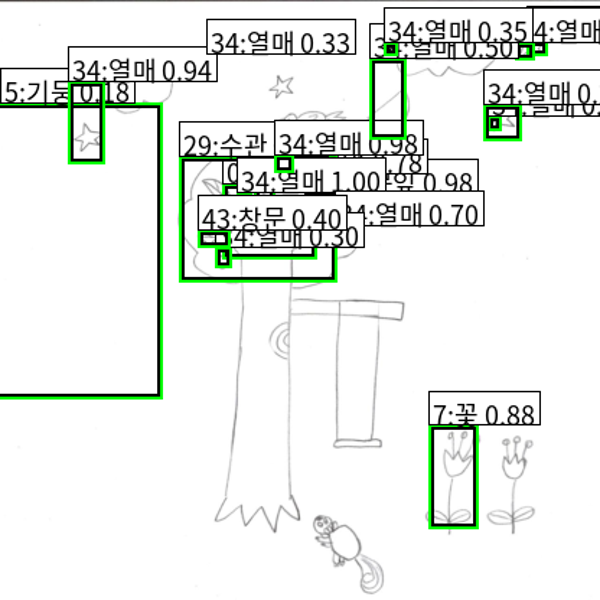

In [ ]:

# 7) 추론 + 시각화(한글)
def _get_font(size=18):
    paths=[
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try: return ImageFont.truetype(p,size)
        except: pass
    return ImageFont.load_default()

def nms_np(boxes, scores, iou_th=0.5):
    if len(boxes)==0: return []
    idxs=np.argsort(-scores); keep=[]
    def iou(a,b):
        ax1,ay1,ax2,ay2=a; bx1,by1,bx2,by2=b
        ix1=max(ax1,bx1); iy1=max(ay1,by1); ix2=min(ax2,bx2); iy2=min(ay2,by2)
        iw=max(0.0, ix2-ix1); ih=max(0.0, iy2-iy1); inter=iw*ih
        areaA=(ax2-ax1)*(ay2-ay1); areaB=(bx2-bx1)*(by2-by1)
        return inter/(areaA+areaB-inter+1e-9)
    while len(idxs)>0:
        i=idxs[0]; keep.append(i)
        rest=idxs[1:]
        idxs=np.array([j for j in rest if iou(boxes[i], boxes[j])<iou_th], dtype=np.int64)
    return keep

@torch.no_grad()
def infer_image(img_path, conf_th=0.15, iou_th=0.45):
    im=Image.open(img_path).convert("RGB")
    im_lb,s,px,py=letterbox(im, INPUT_SIZE)
    arr=np.transpose(np.asarray(im_lb,np.float32)/255.0,(2,0,1))
    t=torch.from_numpy(arr).unsqueeze(0).to(DEVICE)
    out=model(t)  # dict
    boxes_all=[]; scores_all=[]; labels_all=[]
    for S in [13,26,52]:
        pred=out[S][0].cpu().numpy()  # (3,S,S,5+C)
        stride=INPUT_SIZE//S; anchors=np.array(ANCHORS_SCALED[S],np.float32)
        for a in range(3):
            for gy in range(S):
                for gx in range(S):
                    tx,ty,tw,th,to = pred[a,gy,gx,:5]
                    obj=1/(1+np.exp(-to))
                    cls_logits=pred[a,gy,gx,5:]
                    cls_prob=1/(1+np.exp(-cls_logits))
                    cidx=int(np.argmax(cls_prob)) if cls_prob.size>0 else 0
                    conf=obj*(cls_prob[cidx] if cls_prob.size>0 else obj)
                    if conf < conf_th: continue
                    cx=(1/(1+np.exp(-tx))+gx)*stride; cy=(1/(1+np.exp(-ty))+gy)*stride
                    bw=anchors[a,0]*np.exp(tw); bh=anchors[a,1]*np.exp(th)
                    x1,y1,x2,y2=cx-bw/2, cy-bh/2, cx+bw/2, cy+bh/2
                    boxes_all.append([x1,y1,x2,y2]); scores_all.append(float(conf)); labels_all.append(cidx)
    if len(boxes_all)==0:
        return im_lb, ([],[],[])
    boxes_all=np.array(boxes_all,np.float32); scores_all=np.array(scores_all,np.float32); labels_all=np.array(labels_all,np.int32)
    final_boxes=[]; final_scores=[]; final_labels=[]
    for c in np.unique(labels_all):
        idxs=np.where(labels_all==c)[0]; keep=nms_np(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist()); final_scores.append(float(scores_all[idxs][k])); final_labels.append(int(c))
    draw=im_lb.copy(); dr=ImageDraw.Draw(draw); font=_get_font(18)
    W,H=draw.size; th=max(2,int(max(W,H)/512*2)); pad=3
    for (x1,y1,x2,y2),s,c in zip(final_boxes,final_scores,final_labels):
        dr.rectangle([x1,y1,x2,y2], outline=(0,0,0), width=th+2)
        dr.rectangle([x1,y1,x2,y2], outline=(0,255,0), width=th)
        text=f"{c}:{classes[c]} {s:.2f}"
        tx1,ty1,tx2,ty2=dr.textbbox((0,0),text,font=font); tw,tht=tx2-tx1,ty2-ty1
        bx1=max(0,int(x1)); by1=int(y1-tht-2*pad);
        if by1<0: by1=int(y1)
        bx2=min(W, bx1+tw+2*pad); by2=min(H, by1+tht+2*pad)
        dr.rectangle([bx1,by1,bx2,by2], fill=(255,255,255))
        dr.rectangle([bx1,by1,bx2,by2], outline=(0,0,0), width=1)
        dr.text((bx1+pad,by1+pad), text, fill=(0,0,0), font=font)
    return draw, (final_boxes, final_scores, final_labels)

# 샘플 1장 시각화
sample_img = train_items[9]["img_path"] if len(train_items:=train_items if 'train_items' in globals() else [items[0]])>0 else items[0]["img_path"]
drawn,_=infer_image(sample_img)
display(drawn.resize((600,600)))


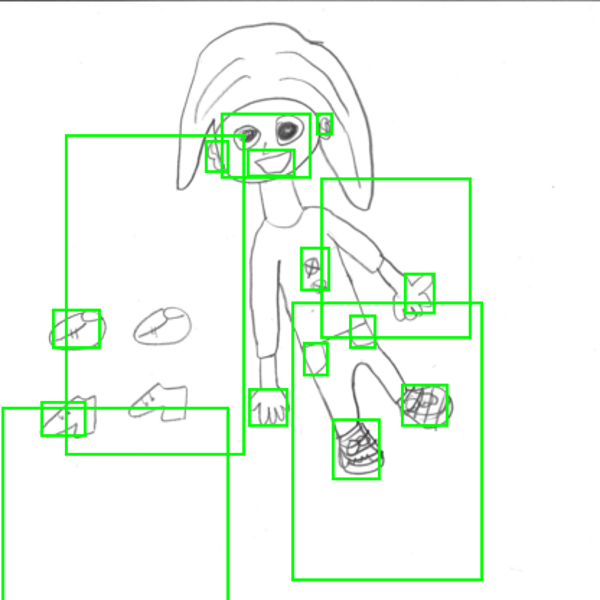

In [ ]:
@torch.no_grad()
def infer_image(img_path, conf_th=0.15, iou_th=0.45):
    im = Image.open(img_path).convert("RGB")
    im_lb, s, px, py = letterbox(im, INPUT_SIZE)
    arr = np.transpose(np.asarray(im_lb, np.float32) / 255.0, (2, 0, 1))
    t = torch.from_numpy(arr).unsqueeze(0).to(DEVICE)

    out = model(t)  # dict: {13: ..., 26: ..., 52: ...}
    boxes_all, scores_all, labels_all = [], [], []

    for S in [13, 26, 52]:
        pred = out[S][0].cpu().numpy()  # (3, S, S, 5+C)
        stride = INPUT_SIZE // S
        anchors = np.array(ANCHORS_SCALED[S], np.float32)

        for a in range(3):
            for gy in range(S):
                for gx in range(S):
                    tx, ty, tw, th, to = pred[a, gy, gx, :5]
                    obj = 1 / (1 + np.exp(-to))

                    # 클래스 확률 계산은 그대로 두되(필터링 일관성), 시각화에는 사용 안함
                    cls_logits = pred[a, gy, gx, 5:]
                    if cls_logits.size > 0:
                        cls_prob = 1 / (1 + np.exp(-cls_logits))
                        cidx = int(np.argmax(cls_prob))
                        conf = obj * cls_prob[cidx]
                    else:
                        conf = obj

                    if conf < conf_th:
                        continue

                    cx = (1 / (1 + np.exp(-tx)) + gx) * stride
                    cy = (1 / (1 + np.exp(-ty)) + gy) * stride
                    bw = anchors[a, 0] * np.exp(tw)
                    bh = anchors[a, 1] * np.exp(th)

                    x1, y1, x2, y2 = cx - bw / 2, cy - bh / 2, cx + bw / 2, cy + bh / 2
                    boxes_all.append([x1, y1, x2, y2])
                    scores_all.append(float(conf))
                    labels_all.append(0)  # 레이블은 사용하지 않지만 NMS 루프 구조를 위해 더미로 0

    if len(boxes_all) == 0:
        return im_lb, ([], [], [])

    boxes_all = np.array(boxes_all, np.float32)
    scores_all = np.array(scores_all, np.float32)
    labels_all = np.array(labels_all, np.int32)

    # 클래스별 NMS이지만, 지금은 모두 같은 '탐지만'이라 0 하나뿐
    final_boxes, final_scores, final_labels = [], [], []
    for c in np.unique(labels_all):
        idxs = np.where(labels_all == c)[0]
        keep = nms_np(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist())
            final_scores.append(float(scores_all[idxs][k]))
            final_labels.append(int(c))

    # === 박스만 그리기 ===
    draw = im_lb.copy()
    dr = ImageDraw.Draw(draw)
    W, H = draw.size
    box_th = max(2, int(max(W, H) / 512 * 2))

    for (x1, y1, x2, y2) in final_boxes:
        dr.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=box_th)

    return draw, (final_boxes, final_scores, final_labels)

# 샘플 1장 시각화 (박스만)
sample_img = train_items[24]["img_path"] if len(train_items := train_items if 'train_items' in globals() else [items[0]]) > 0 else items[0]["img_path"]
drawn, _ = infer_image(sample_img)
display(drawn.resize((600, 600)))

### GT 박스로 분류 학습 데이터 만들기

In [ ]:
import os, shutil
from pathlib import Path
from PIL import Image

def export_classifier_crops_from_gt(items, out_dir="cls_crops_gt", min_size=8):
    """
    items: [{"img_path":..., "bboxes":[{"x","y","w","h","label"}, ...]}, ...]
    out_dir: ImageFolder 구조로 저장 (label/xxx.jpg)
    """
    out = Path(out_dir)
    if out.exists():
        shutil.rmtree(out)
    out.mkdir(parents=True, exist_ok=True)

    n_ok = 0
    for it in items:
        img_path = it["img_path"]
        im = Image.open(img_path).convert("RGB")
        W, H = im.size
        for i, bb in enumerate(it["bboxes"]):
            x, y, w, h = float(bb["x"]), float(bb["y"]), float(bb["w"]), float(bb["h"])
            if w < min_size or h < min_size:
                continue
            x1, y1 = int(max(0, x)), int(max(0, y))
            x2, y2 = int(min(W, x + w)), int(min(H, y + h))
            if x2 <= x1 or y2 <= y1:
                continue
            crop = im.crop((x1, y1, x2, y2))
            cls_name = str(bb.get("label", "unknown"))
            cls_dir = out / cls_name
            cls_dir.mkdir(parents=True, exist_ok=True)
            save_name = f"{Path(img_path).stem}_{i}.jpg"
            crop.save(cls_dir / save_name, quality=95)
            n_ok += 1
    print(f"[OK] saved {n_ok} crops to {out.resolve()}")
    return out.resolve()

train_crops_dir = export_classifier_crops_from_gt(train_items, "cls_crops_gt_train")
val_crops_dir   = export_classifier_crops_from_gt(val_items,   "cls_crops_gt_val")

[OK] saved 12419 crops to /content/cls_crops_gt_train
[OK] saved 1386 crops to /content/cls_crops_gt_val


### 간단 분류기(ResNet-18) 학습

In [ ]:
import torch, torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

tf_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
tf_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

ds_train = torchvision.datasets.ImageFolder(Path("cls_crops_gt_train"), tf_train)
ds_val   = torchvision.datasets.ImageFolder(Path("cls_crops_gt_val"),   tf_val)
num_classes_cls = len(ds_train.classes)
cls_idx2name = {i:n for i,n in enumerate(ds_train.classes)}

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
dl_val   = DataLoader(ds_val,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

def build_resnet18(num_classes):
    try:
        m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    except Exception:
        m = torchvision.models.resnet18(weights=None)
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, num_classes)
    return m

cls_model = build_resnet18(num_classes_cls).to(DEVICE)
opt = torch.optim.Adam(cls_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_ce = nn.CrossEntropyLoss()

def train_cls_ep():
    cls_model.train(); total=0.0; correct=0; n=0
    for x,y in dl_train:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = cls_model(x)
        loss = criterion_ce(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*y.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); n += y.size(0)
    return total/n, correct/n

@torch.no_grad()
def val_cls_ep():
    cls_model.eval(); total=0.0; correct=0; n=0
    for x,y in dl_val:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = cls_model(x)
        loss = criterion_ce(logits, y)
        total += loss.item()*y.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); n += y.size(0)
    return total/n, correct/n

EPOCHS = 5  # 데이터 양에 따라 5~20
best = 0.0
for ep in range(1, EPOCHS+1):
    tl, ta = train_cls_ep()
    vl, va = val_cls_ep()
    print(f"[{ep:02d}] train loss {tl:.3f} acc {ta:.3f} | val loss {vl:.3f} acc {va:.3f}")
    if va > best:
        best = va
        torch.save({"model": cls_model.state_dict(), "classes": ds_train.classes}, "cls_resnet18_best.pt")
        print("  ↳ best classifier saved")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


[01] train loss 1.576 acc 0.552 | val loss 1.955 acc 0.447
  ↳ best classifier saved
[02] train loss 1.087 acc 0.676 | val loss 1.555 acc 0.536
  ↳ best classifier saved
[03] train loss 0.944 acc 0.708 | val loss 1.440 acc 0.578
  ↳ best classifier saved
[04] train loss 0.882 acc 0.731 | val loss 1.430 acc 0.602
  ↳ best classifier saved
[05] train loss 0.782 acc 0.757 | val loss 1.398 acc 0.641
  ↳ best classifier saved


### E2E 추론: 검출 → 역보정 → crop → 분류 → 최종 라벨

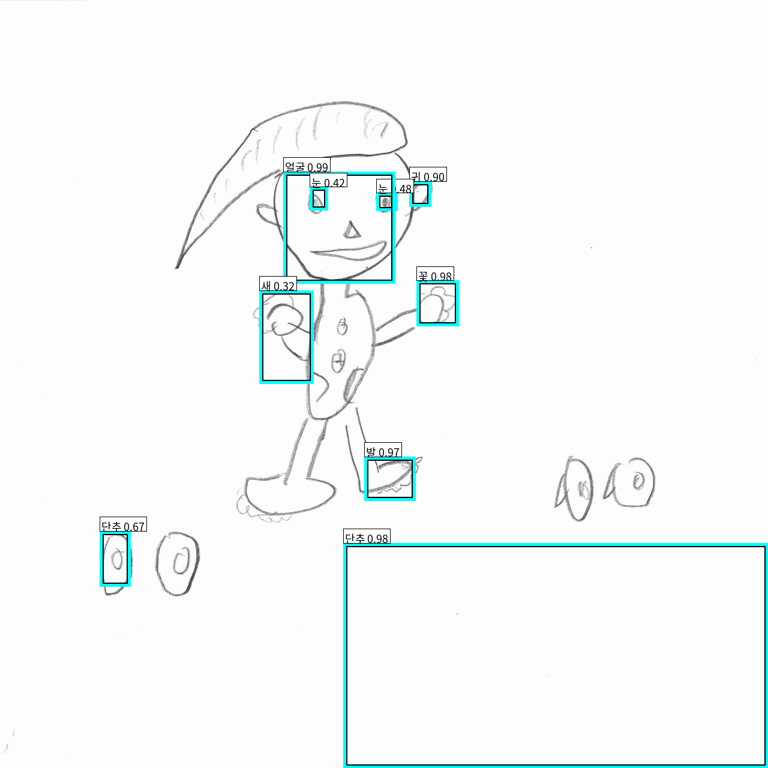

{'box_orig': [682, 302, 718, 344], 'det_conf': 0.9968208074569702, 'det_yolo_class': '가지', 'cls_name': '귀', 'cls_score': 0.8992661237716675}
{'box_orig': [627, 321, 662, 351], 'det_conf': 0.9218549132347107, 'det_yolo_class': '가지', 'cls_name': '눈', 'cls_score': 0.48236626386642456}
{'box_orig': [694, 467, 764, 543], 'det_conf': 0.8785935044288635, 'det_yolo_class': '가지', 'cls_name': '꽃', 'cls_score': 0.9840236902236938}
{'box_orig': [607, 761, 692, 834], 'det_conf': 0.4878750145435333, 'det_yolo_class': '가지', 'cls_name': '발', 'cls_score': 0.9733203053474426}
{'box_orig': [472, 286, 658, 472], 'det_conf': 0.37706056237220764, 'det_yolo_class': '가지', 'cls_name': '얼굴', 'cls_score': 0.9865058064460754}
{'box_orig': [572, 905, 1280, 1280], 'det_conf': 0.2577960789203644, 'det_yolo_class': '가지', 'cls_name': '단추', 'cls_score': 0.9810580015182495}
{'box_orig': [166, 885, 217, 977], 'det_conf': 0.2229328155517578, 'det_yolo_class': '가지', 'cls_name': '단추', 'cls_score': 0.6681511402130127}
{'box_

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn.functional as F

def _get_font(size=18):
    paths = [
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except:
            pass
    return ImageFont.load_default()

def de_letterbox_xyxy(x1,y1,x2,y2, scale, pad_x, pad_y):
    ox1 = (x1 - pad_x) / scale
    oy1 = (y1 - pad_y) / scale
    ox2 = (x2 - pad_x) / scale
    oy2 = (y2 - pad_y) / scale
    return ox1, oy1, ox2, oy2

@torch.no_grad()
def detect_then_classify(img_path, conf_th=0.15, iou_th=0.45):
    """
    YOLO infer_image() 결과를 받아 원본 좌표로 역보정 → crop → 분류 → 최종 라벨.
    반환: (preds: list, vis_img: PIL)
    """
    # 1) letterbox 파라미터 계산 (infer_image와 동일 INPUT_SIZE 사용)
    im = Image.open(img_path).convert("RGB")
    im_lb, scale, pad_x, pad_y = letterbox(im, INPUT_SIZE)

    # 2) YOLO 추론 호출 — ✅ 모델 인자 제거, 키워드 중복 제거
    drawn, (lb_boxes, lb_scores, lb_labels) = infer_image(img_path, conf_th=conf_th, iou_th=iou_th)

    preds = []
    for (x1,y1,x2,y2), s, yolo_c in zip(lb_boxes, lb_scores, lb_labels):
        # 3) 원본 좌표로 역보정
        ox1, oy1, ox2, oy2 = de_letterbox_xyxy(x1,y1,x2,y2, scale, pad_x, pad_y)
        ox1, oy1 = int(max(0, ox1)), int(max(0, oy1))
        ox2, oy2 = int(min(im.width, ox2)), int(min(im.height, oy2))
        if ox2 <= ox1 or oy2 <= oy1:
            continue
        crop = im.crop((ox1, oy1, ox2, oy2))

        # 4) 분류
        x = tf_val(crop).unsqueeze(0).to(DEVICE)  # tf_val: 위에서 정의한 전처리
        logits = cls_model(x)
        prob = F.softmax(logits, dim=1)[0]
        cid = int(prob.argmax().item())
        cname = cls_idx2name[cid]
        cscore = float(prob.max().item())

        preds.append({
            "box_orig": [ox1,oy1,ox2,oy2],
            "det_conf": float(s),
            "det_yolo_class": idx2cls.get(int(yolo_c), str(yolo_c)) if 'idx2cls' in globals() else int(yolo_c),
            "cls_name": cname,
            "cls_score": cscore,
        })

    # 5) 최종 시각화 (분류 라벨 기준, 시안색)
    draw = im.copy()
    dr = ImageDraw.Draw(draw)
    font = _get_font(18)
    W,H = draw.size
    thick = max(2, int(max(W,H)/512*2)); pad = 3
    for p in preds:
        x1,y1,x2,y2 = p["box_orig"]
        dr.rectangle([x1,y1,x2,y2], outline=(0,0,0), width=thick+2)
        dr.rectangle([x1,y1,x2,y2], outline=(0,255,255), width=thick)
        text = f"{p['cls_name']} {p['cls_score']:.2f}"
        tx1,ty1,tx2,ty2 = dr.textbbox((0,0), text, font=font)
        tw, th = tx2-tx1, ty2-ty1
        bx1 = max(0, x1); by1 = y1 - th - 2*pad
        if by1 < 0: by1 = y1
        bx2 = min(W, bx1 + tw + 2*pad); by2 = min(H, by1 + th + 2*pad)
        dr.rectangle([bx1,by1,bx2,by2], fill=(255,255,255))
        dr.rectangle([bx1,by1,bx2,by2], outline=(0,0,0), width=1)
        dr.text((bx1+pad,by1+pad), text, fill=(0,0,0), font=font)

    return preds, draw

# === 한 장 테스트 ===
sample_img = train_items[30]["img_path"]
preds, vis = detect_then_classify(sample_img, conf_th=0.15, iou_th=0.45)
display(vis.resize((768,768)))
for p in preds:
    print(p)


### 데이터셋 전체 돌려서 저장

In [ ]:
from pathlib import Path

def run_e2e_and_save(items, out_dir="e2e_results", conf_th=0.15, iou_th=0.45):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    for it in items:
        img_path = it["img_path"]
        preds, vis = detect_then_classify(img_path, conf_th=conf_th, iou_th=iou_th)
        save_p = out / (Path(img_path).stem + "_e2e.jpg")
        vis.save(save_p, quality=95)
    print(f"[OK] saved to {out.resolve()}")

# 예시 실행
run_e2e_and_save(val_items[:20], out_dir="e2e_results_preview")

[OK] saved to /content/e2e_results_preview
